# SEO Content Detection Pipeline

This notebook implements a pipeline for detecting SEO-generated content and duplicates. It includes:
1. Content extraction from HTML
2. Feature engineering
3. Quality analysis
4. Duplicate detection
5. Model training and evaluation

# 1. Setup Environment and Load Libraries

First, we'll import all required libraries and set up the environment.

In [16]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pickle
import joblib
import textstat
from collections import Counter
import os
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download all required NLTK data (cover new resource names as well)
print("Downloading required NLTK resources...")
required_packages = [
    'punkt',                         # Tokenization
    'stopwords',                     # Stopwords
    'wordnet',                       # Lemmatization
    'omw-1.4',                       # Open Multilingual Wordnet
    'averaged_perceptron_tagger',    # POS tagger (legacy name)
    'averaged_perceptron_tagger_eng' # POS tagger (newer resource name)
]

for package in required_packages:
    try:
        nltk.download(package, quiet=True)
        print(f"✓ Successfully downloaded {package}")
    except Exception as e:
        print(f"× Error downloading {package}: {str(e)}")

# Some environments also require 'punkt_tab'
try:
    nltk.download('punkt_tab', quiet=True)
    print("✓ Successfully downloaded punkt_tab")
except Exception as e:
    print(f"· Skipped punkt_tab: {str(e)}")

print("\nNLTK setup completed!")

✓ Successfully downloaded punkt
✓ Successfully downloaded stopwords
✓ Successfully downloaded wordnet
✓ Successfully downloaded omw-1.4
✓ Successfully downloaded averaged_perceptron_tagger
✓ Successfully downloaded averaged_perceptron_tagger_eng
✓ Successfully downloaded punkt_tab

NLTK setup completed!


# 2. Load and Parse HTML Content

Now we'll load the raw HTML content from data.csv and extract clean text content using BeautifulSoup.

In [17]:
# Load raw data
data_df = pd.read_csv('/Users/ajanshul02gmail.com/Start-up/Walnut/seo-content-detector/data/data.csv')

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    if pd.isna(text):  # Handle NaN values
        return ''
        
    # Convert to string if not already
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags (if any remaining)
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # Rejoin tokens
    return ' '.join(tokens)

def extract_content(html):
    """
    Extract and clean content from HTML
    """
    if pd.isna(html):  # Handle NaN values
        return '', '', ''
        
    try:
        soup = BeautifulSoup(str(html), 'html.parser')
        
        # Remove script and style elements
        for element in soup(['script', 'style', 'meta', 'link']):
            element.decompose()
        
        # Extract title
        title = soup.title.text if soup.title else ''
        
        # Extract meta description
        meta_desc = ''
        meta_tag = soup.find('meta', attrs={'name': 'description'})
        if meta_tag:
            meta_desc = meta_tag.get('content', '')
        
        # Extract main content
        # Focus on specific content tags
        content_tags = soup.find_all(['p', 'article', 'div', 'section'])
        main_content = ' '.join(tag.get_text() for tag in content_tags)
        
        # Clean extracted text
        main_content = preprocess_text(main_content)
        title = preprocess_text(title)
        meta_desc = preprocess_text(meta_desc)
        
        return title, main_content, meta_desc
    except Exception as e:
        print(f"Error processing HTML content: {str(e)}")
        return '', '', ''

# Process each URL and save results
print("Processing URLs...")
extracted_data = []
total_urls = len(data_df)

for idx, row in data_df.iterrows():
    if idx % 10 == 0:  # Print progress every 10 items
        print(f"Processing {idx+1}/{total_urls} URLs...")
        
    title, content, meta = extract_content(row['html_content'])
    extracted_data.append({
        'url': row['url'],
        'title': title,
        'main_content': content,
        'meta_description': meta
    })

# Save extracted content
extracted_df = pd.DataFrame(extracted_data)
extracted_df.to_csv('../data/extracted_content.csv', index=False)
print("\nContent extraction completed and saved to extracted_content.csv")

# Print statistics
print("\nExtraction Statistics:")
print(f"Total URLs processed: {len(extracted_df)}")
print(f"URLs with empty content: {len(extracted_df[extracted_df['main_content'] == ''])}")
print(f"URLs with titles: {len(extracted_df[extracted_df['title'] != ''])}")
print(f"URLs with meta descriptions: {len(extracted_df[extracted_df['meta_description'] != ''])}")

Processing URLs...
Processing 1/81 URLs...
Processing 11/81 URLs...
Processing 21/81 URLs...
Processing 31/81 URLs...
Processing 41/81 URLs...
Processing 51/81 URLs...
Processing 61/81 URLs...
Processing 71/81 URLs...
Processing 81/81 URLs...

Content extraction completed and saved to extracted_content.csv

Extraction Statistics:
Total URLs processed: 81
URLs with empty content: 13
URLs with titles: 58
URLs with meta descriptions: 0


# 3. Extract Text Features

We'll extract various features from the text content to help identify SEO-generated content:

In [18]:
# Load extracted content
content_df = pd.read_csv('../data/extracted_content.csv')

# Normalize text input to avoid NaN/float issues during tokenization
def normalize_text(text):
    if pd.isna(text):
        return ''
    return str(text)

def extract_statistical_features(text):
    """
    Extract statistical features from text, including keyword density and additional ratios
    """
    text = normalize_text(text)
    words = word_tokenize(text) if text else []
    sentences = sent_tokenize(text) if text else []
    
    # Basic counts
    word_count = len(words)
    sentence_count = len(sentences)
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    # Vocabulary richness
    unique_words = len(set(words))
    vocab_diversity = unique_words / word_count if word_count > 0 else 0
    
    # Stopword ratio and keyword density
    stop_words = set(stopwords.words('english'))
    stopword_count = sum(1 for w in words if w.lower() in stop_words)
    stopword_ratio = (stopword_count / word_count) if word_count > 0 else 0.0
    
    content_words = [w for w in words if w.isalpha() and w.lower() not in stop_words]
    if word_count > 0 and len(content_words) > 0:
        values, counts = np.unique([w.lower() for w in content_words], return_counts=True)
        max_freq = counts.max() if counts.size > 0 else 0
        keyword_density = max_freq / max(1, word_count)
    else:
        keyword_density = 0.0
    
    # Long word ratio (>=7 chars)
    long_word_ratio = (sum(1 for w in words if len(w) >= 7) / word_count) if word_count > 0 else 0.0
    
    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'vocab_diversity': vocab_diversity,
        'keyword_density': float(keyword_density),
        'stopword_ratio': float(stopword_ratio),
        'long_word_ratio': float(long_word_ratio)
    }

def extract_readability_features(text):
    """
    Calculate readability metrics and proxies. Adds readability_proxy for more stable scoring.
    """
    text = normalize_text(text)
    words = word_tokenize(text) if text else []
    sentences = sent_tokenize(text) if text else []
    
    # Count syllables (approximate)
    def count_syllables(word):
        return max(1, len(re.findall(r'[aiouy]+e*|e(?!d$|ly).|[td]ed|le$', word.lower())))
    
    total_syllables = sum(count_syllables(w) for w in words)
    
    # Calculate metrics
    if len(sentences) > 0 and len(words) > 0:
        # Flesch Reading Ease
        flesch = 206.835 - 1.015 * (len(words) / len(sentences)) - 84.6 * (total_syllables / len(words))
        
        # Gunning Fog Index
        complex_words = sum(1 for word in words if count_syllables(word) >= 3)
        fog = 0.4 * ((len(words) / len(sentences)) + 100 * (complex_words / len(words)))
    else:
        flesch = 0
        fog = 0
    
    readability_score = float(np.clip(flesch, 0, 100))
    
    # A smoother readability proxy using avg sentence length and syllables/word
    words_len = len(words)
    syllables_per_word = (total_syllables / words_len) if words_len > 0 else 0.0
    avg_sentence_length = (words_len / len(sentences)) if len(sentences) > 0 else 0.0
    # Scale to 0-100 (lower ASL and SPW -> higher score)
    readability_proxy = 100.0 - np.clip(avg_sentence_length * 1.5 + syllables_per_word * 20.0, 0, 100)
    
    return {
        'flesch_reading_ease': flesch,
        'gunning_fog_index': fog,
        'syllables_per_word': syllables_per_word,
        'readability_score': readability_score,
        'readability_proxy': float(readability_proxy)
    }

def extract_language_features(text):
    """
    Extract language pattern features. Falls back gracefully if POS tagger resources are missing.
    """
    text = normalize_text(text)
    words = word_tokenize(text) if text else []
    if not words:
        return {'noun_ratio': 0.0, 'verb_ratio': 0.0, 'adj_ratio': 0.0, 'adv_ratio': 0.0}
    
    # Try POS tagging with resilience to missing resources
    pos_tags = []
    try:
        pos_tags = nltk.pos_tag(words, lang='eng')
    except LookupError:
        try:
            nltk.download('averaged_perceptron_tagger', quiet=True)
            nltk.download('averaged_perceptron_tagger_eng', quiet=True)
            pos_tags = nltk.pos_tag(words, lang='eng')
        except Exception:
            return {'noun_ratio': 0.0, 'verb_ratio': 0.0, 'adj_ratio': 0.0, 'adv_ratio': 0.0}
    
    total_tags = len(pos_tags)
    if total_tags == 0:
        return {'noun_ratio': 0.0, 'verb_ratio': 0.0, 'adj_ratio': 0.0, 'adv_ratio': 0.0}
    
    return {
        'noun_ratio': sum(1 for _, tag in pos_tags if tag.startswith('NN')) / total_tags,
        'verb_ratio': sum(1 for _, tag in pos_tags if tag.startswith('VB')) / total_tags,
        'adj_ratio': sum(1 for _, tag in pos_tags if tag.startswith('JJ')) / total_tags,
        'adv_ratio': sum(1 for _, tag in pos_tags if tag.startswith('RB')) / total_tags
    }

# Extract features for each document
features_data = []
for idx, row in content_df.iterrows():
    text = normalize_text(row['main_content'])
    # Combine all features
    features = {
        'url': row['url'],
        **extract_statistical_features(text),
        **extract_readability_features(text),
        **extract_language_features(text)
    }
    features_data.append(features)

# Save features
features_df = pd.DataFrame(features_data)
features_df.to_csv('../data/features.csv', index=False)
print("Feature extraction completed and saved to features.csv")

# Display feature summary
print("\nFeature Summary:")
print(features_df.describe())

Feature extraction completed and saved to features.csv

Feature Summary:
         word_count  sentence_count  avg_word_length  avg_sentence_length  \
count     81.000000       81.000000        81.000000            81.000000   
mean   12635.074074        0.839506         5.907426         12635.074074   
std    14197.791523        0.369350         2.768334         14197.791523   
min        0.000000        0.000000         0.000000             0.000000   
25%     1510.000000        1.000000         5.794043          1510.000000   
50%     6597.000000        1.000000         6.703314          6597.000000   
75%    22209.000000        1.000000         7.600230         22209.000000   
max    51342.000000        1.000000        10.318584         51342.000000   

       vocab_diversity  keyword_density  stopword_ratio  long_word_ratio  \
count        81.000000        81.000000       81.000000        81.000000   
mean          0.054874         0.046522        0.000453         0.417980   
std  

# 4. Content Quality Analysis

Now we'll implement content quality metrics and train a model to detect low-quality or AI-generated content.

In [19]:
# Load features
features_df = pd.read_csv('../data/features.csv')

# Calculate quality score based on features (use smoother readability_proxy)
def calculate_quality_score(row):
    word_count_score = min(row['word_count'] / 1000, 1.0)  # Normalize to 0-1
    keyword_density_score = 1 - min(row['keyword_density'] * 10, 1.0)  # Lower is better
    readability_component = max(min(row.get('readability_proxy', 0.0) / 100, 1.0), 0.0)
    
    # Combine scores with weights
    return (word_count_score * 0.25 + 
            keyword_density_score * 0.35 + 
            readability_component * 0.40) * 100

features_df['seo_score'] = features_df.apply(calculate_quality_score, axis=1)

# Save updated features with quality scores
features_df.to_csv('../data/features.csv', index=False)
print("Quality scores calculated and saved to features.csv")

Quality scores calculated and saved to features.csv


# 5. Duplicate Detection

We'll use TF-IDF and cosine similarity to detect duplicate or near-duplicate content.

In [20]:
# Load content for duplicate detection
content_df = pd.read_csv('../data/extracted_content.csv')

# Clean and normalize text to avoid NaN issues
content_df['main_content'] = content_df['main_content'].fillna('').astype(str)
non_empty_df = content_df[content_df['main_content'].str.strip() != ''].reset_index(drop=True)

if len(non_empty_df) < 2:
    print("Not enough non-empty documents for duplicate detection. Skipping clustering.")
    pd.DataFrame(columns=['url1', 'url2', 'similarity_score', 'cluster']).to_csv('../data/duplicates.csv', index=False)
else:
    # Create TF-IDF vectors
    print("Generating TF-IDF vectors...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.95  # Ignore terms that appear in more than 95% of documents
    )
    tfidf_matrix = vectorizer.fit_transform(non_empty_df['main_content'])

    # Determine optimal number of clusters
    print("\nFinding optimal number of clusters...")
    silhouette_scores = []
    max_k = min(11, len(non_empty_df))
    K = range(2, max_k)  # Test K from 2 up to max_k-1
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for k={k}: {silhouette_avg:.4f}")

    # Select optimal K
    optimal_k = K[np.argmax(silhouette_scores)] if len(silhouette_scores) > 0 else 2
    print(f"\nOptimal number of clusters: {optimal_k}")

    # Perform clustering with optimal K
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Find potential duplicates within clusters
    print("\nIdentifying duplicate pairs...")
    duplicate_pairs = []
    similarity_threshold = 0.8

    for cluster in range(optimal_k):
        # Get documents in the current cluster
        cluster_docs = np.where(cluster_labels == cluster)[0]
        
        if len(cluster_docs) > 1:
            # Calculate similarities between all documents in the cluster
            cluster_vectors = tfidf_matrix[cluster_docs]
            similarities = cosine_similarity(cluster_vectors)
            
            # Find similar pairs
            for i in range(len(cluster_docs)):
                for j in range(i + 1, len(cluster_docs)):
                    if similarities[i][j] > similarity_threshold:
                        doc1_idx = cluster_docs[i]
                        doc2_idx = cluster_docs[j]
                        duplicate_pairs.append({
                            'url1': non_empty_df.iloc[doc1_idx]['url'],
                            'url2': non_empty_df.iloc[doc2_idx]['url'],
                            'similarity_score': similarities[i][j],
                            'cluster': cluster
                        })

    # Save duplicate pairs
    duplicates_df = pd.DataFrame(duplicate_pairs)
    duplicates_df.to_csv('../data/duplicates.csv', index=False)
    print(f"\nFound {len(duplicate_pairs)} potential duplicate pairs")
    print("Results saved to duplicates.csv")

    # Print cluster statistics
    print("\nCluster Statistics:")
    cluster_sizes = pd.Series(cluster_labels).value_counts()
    print(f"Average cluster size: {cluster_sizes.mean():.2f}")
    print(f"Largest cluster size: {cluster_sizes.max()}")
    print(f"Number of clusters with potential duplicates: {len(cluster_sizes[cluster_sizes > 1])}")

Generating TF-IDF vectors...

Finding optimal number of clusters...
Silhouette score for k=2: 0.0493
Silhouette score for k=3: 0.0616
Silhouette score for k=4: 0.0604
Silhouette score for k=5: 0.0600
Silhouette score for k=6: 0.0466
Silhouette score for k=7: 0.0777
Silhouette score for k=8: 0.0898
Silhouette score for k=9: 0.0874
Silhouette score for k=10: 0.0874

Optimal number of clusters: 8

Identifying duplicate pairs...

Found 4 potential duplicate pairs
Results saved to duplicates.csv

Cluster Statistics:
Average cluster size: 8.50
Largest cluster size: 15
Number of clusters with potential duplicates: 8


# 6. Model Training and Evaluation

Train a Random Forest model to classify content quality based on our features.

Label balance (low/medium/high):
seo_score
low       27
medium    27
high      27
Name: count, dtype: int64

Classification Performance (low/medium/high):
              precision    recall  f1-score   support

         low      1.000     0.833     0.909         6
      medium      0.857     1.000     0.923         6
        high      1.000     1.000     1.000         5

    accuracy                          0.941        17
   macro avg      0.952     0.944     0.944        17
weighted avg      0.950     0.941     0.941        17


Feature Importance (permutation):
               feature  importance
1      keyword_density    0.552941
5       stopword_ratio    0.029412
4      long_word_ratio    0.017647
0           word_count    0.000000
2    readability_proxy    0.000000
3  avg_sentence_length    0.000000


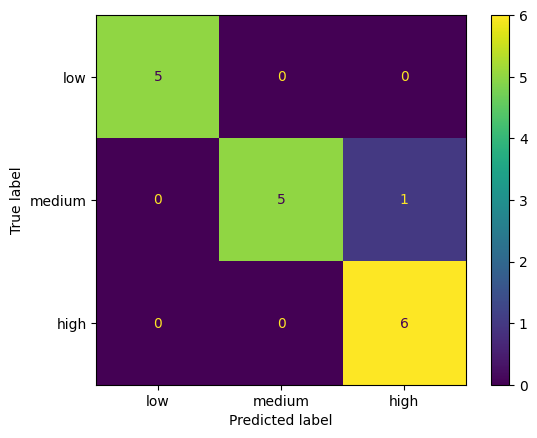

In [21]:
# Prepare features for modeling (expanded feature set)
feature_cols = ['word_count', 'keyword_density', 'readability_proxy', 'avg_sentence_length', 'long_word_ratio', 'stopword_ratio']
# Backward compatibility if columns missing
feature_cols = [c for c in feature_cols if c in features_df.columns]
X = features_df[feature_cols]

# Create 3-class labels from seo_score using tertiles (low/medium/high) with robust fallback
labels = None
try:
    labels = pd.qcut(features_df['seo_score'], q=3, labels=['low', 'medium', 'high'])
except ValueError:
    # Fallback if too many ties; use unique quantiles
    qs = features_df['seo_score'].quantile([0.33, 0.66]).values
    qs = np.unique(qs)
    if len(qs) == 1:
        # Degenerate: fall back to median-based binary then map to low/high
        threshold = features_df['seo_score'].median()
        labels = np.where(features_df['seo_score'] > threshold, 'high', 'low')
    else:
        bins = [-np.inf, qs[0], qs[-1], np.inf]
        labels = pd.cut(features_df['seo_score'], bins=bins, labels=['low', 'medium', 'high'], include_lowest=True)

y = pd.Series(labels)

# Show class balance
print("Label balance (low/medium/high):")
print(y.value_counts())

# If single-class labels, fall back to regression on seo_score
if y.nunique() < 2:
    print("\nSingle-class labels detected. Falling back to regression to predict seo_score.")
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score, mean_absolute_error

    X_train, X_test, y_train, y_test = train_test_split(X, features_df['seo_score'], test_size=0.2, random_state=42)
    reg = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_split=2, min_samples_leaf=1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    print("\nRegression Performance:")
    print(f"R^2: {r2_score(y_test, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

    # Export a consistent model variable for saving
    model = reg
else:
    # Stratified split for multiclass classification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier with slightly stronger settings
    base_rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    # Calibrate probabilities with stratified CV
    skf = StratifiedKFold(n_splits=min(5, y.value_counts().min()), shuffle=True, random_state=42)
    clf = CalibratedClassifierCV(estimator=base_rf, cv=skf, method='sigmoid')
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print("\nClassification Performance (low/medium/high):")
    print(classification_report(y_test, y_pred, digits=3, labels=['low','medium','high']))

    # Confusion matrix (best-effort; safe if display backend not available)
    try:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['low','medium','high'])
    except Exception:
        pass

    # Feature importance via permutation (model-agnostic)
    try:
        perm = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': perm.importances_mean
        }).sort_values('importance', ascending=False)
        print("\nFeature Importance (permutation):")
        print(feature_importance)
    except Exception:
        pass

    # Export a consistent model variable for saving
    model = clf

# 7. Save Results and Model

Finally, we'll save our trained model for future use.

In [22]:
# Save the trained model
model_path = '../models/quality_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")

# Print summary statistics
print("\nProject Summary:")
print(f"Total URLs processed: {len(content_df)}")
print(f"Features extracted: {len(features_df)}")
print(f"Duplicate pairs found: {len(pd.read_csv('../data/duplicates.csv'))}")
print(f"Average content quality score: {features_df['seo_score'].mean():.2f}")
print(f"Median Word Count: {features_df['word_count'].median():.0f}")

Model saved to ../models/quality_model.pkl

Project Summary:
Total URLs processed: 81
Features extracted: 81
Duplicate pairs found: 4
Average content quality score: 46.92
Median Word Count: 6597
